In [341]:
from pydantic_settings import BaseSettings
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import os
import time
import uuid
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sqlalchemy.sql import text
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import List, TypedDict, Dict, Any, Optional
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage,  SystemMessage
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine, Column, Integer, Float, String, MetaData, Table, text, inspect
from langgraph.checkpoint.postgres import PostgresSaver
from langchain_core.runnables.config import RunnableConfig
load_dotenv()

True

In [342]:
llm = ChatOpenAI(model="gpt-4o-mini")

### Code for uploading the csv file to a database and also connecting to postgres database using sqlalchemy

In [343]:
class Settings(BaseSettings):
    database_hostname: str
    database_port: str
    database_password: str
    database_name: str
    database_username: str

    openai_api_key: str
    langsmith_tracing: bool
    langsmith_endpoint: str
    langsmith_api_key: str
    langsmith_project: str
    tavily_api_key: str
    upload_folder: str
    class Config:
        env_file = ".env"
        extra = "allow"


settings = Settings()

In [344]:
# create state for passing data between the nodes for the database creation
class GenerateAnalystsState(TypedDict):
    csv_path: str 
    analysis_goal: str  
    max_analysts: int
    human_analyst_feedback: Optional[str]
    data_database_name: Optional[str] 
    memory_database_name: Optional[str]
    table_name: Optional[str]  
    data_df: Dict[str, Any] 
    ml_models: Dict[str, Any]
    visualizations: Dict[str, str] 
    database_schema: Optional[Dict[str, str]] 
    analysis_summary: Optional[str]
    memory_saver: str
    data_engine: str
    question: str
    sql_query: str
    query_result: str
    query_rows : str
    sql_error: bool
    attempts: int
    relevance: str

In [345]:
def infer_column_types(df):
    """Infer SQL column types from csv file"""
    type_map = {}
    
    for col in df.columns:
        if pd.api.types.is_integer_dtype(df[col]):
            type_map[col] = Integer
        elif pd.api.types.is_float_dtype(df[col]):
            type_map[col] = Float
        else:
            type_map[col] = String(255)
    
    return type_map

In [346]:
def create_databases_and_tables(state: GenerateAnalystsState, df, data_db_name=None, memory_db_name=None, table_name=None):
    """Create two databases: one for storing CSV data and another for memory"""

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    if data_db_name is None:
        data_db_name = settings.database_name
        if data_db_name is None:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            data_db_name = f"analysis_db_{timestamp}"
    if memory_db_name is None:
        memory_db_name = "memory_db"

    if table_name is None:
        table_name = "data_table"

    settings.database_name = data_db_name

    admin_engine = create_engine(
        f"postgresql+psycopg2://{settings.database_username}:{settings.database_password}@"
        f"{settings.database_hostname}:{settings.database_port}/postgres"
    )

    with admin_engine.connect() as conn:
        conn.execution_options(isolation_level="AUTOCOMMIT")
        
        conn.execute(text(f"SELECT pg_terminate_backend(pid) FROM pg_stat_activity WHERE datname = '{data_db_name}'"))
        conn.execute(text(f"DROP DATABASE IF EXISTS {data_db_name}"))
        conn.execute(text(f"CREATE DATABASE {data_db_name}"))

        conn.execute(text(f"SELECT pg_terminate_backend(pid) FROM pg_stat_activity WHERE datname = '{memory_db_name}'"))
        conn.execute(text(f"DROP DATABASE IF EXISTS {memory_db_name}"))
        conn.execute(text(f"CREATE DATABASE {memory_db_name}"))

    # Connect to data database
    data_engine = create_engine(
        f"postgresql+psycopg2://{settings.database_username}:{settings.database_password}@"
        f"{settings.database_hostname}:{settings.database_port}/{data_db_name}"
    )

    # Connect to memory database
    memory_engine = create_engine(
        f"postgresql+psycopg2://{settings.database_username}:{settings.database_password}@"
        f"{settings.database_hostname}:{settings.database_port}/{memory_db_name}"
    )

    # Create table for CSV data
    metadata = MetaData()
    columns = [Column('id', Integer, primary_key=True)]
    schema_info = {'id': 'Integer (primary key)'}

    column_types = infer_column_types(df)
    for col_name, sql_type in column_types.items():
        safe_col_name = col_name.replace(' ', '_').lower()
        columns.append(Column(safe_col_name, sql_type))
        schema_info[safe_col_name] = sql_type.__name__ if isinstance(sql_type, type) else str(sql_type)

    table = Table(table_name, metadata, *columns)
    metadata.create_all(data_engine)

    df_to_insert = df.copy()
    df_to_insert.columns = [col.replace(' ', '_').lower() for col in df.columns]

    with data_engine.connect() as conn:
        batch_size = 1000
        for i in range(0, len(df_to_insert), batch_size):
            batch = df_to_insert.iloc[i:i+batch_size]
            batch.to_sql(table_name, conn, if_exists='append', index=False)

    # Create table for memory storage
    memory_metadata = MetaData()
    memory_table = Table(
        "memory_store", memory_metadata,
        Column("id", Integer, primary_key=True),
        Column("session_id", String, nullable=False),
        Column("state", String, nullable=False)
    )
    memory_metadata.create_all(memory_engine)

    
    memory_saver = PostgresSaver(f"postgresql://{settings.database_username}:{settings.database_password}@"
                                 f"{settings.database_hostname}:{settings.database_port}/{memory_db_name}")
    
    state["data_database_name"] = data_db_name

    return {
        "data_database_name": data_db_name,
        "memory_database_name": memory_db_name,
        "table_name": table_name,
        "data_engine": data_engine,
        "memory_engine": memory_engine,
        "schema": schema_info,
        "memory_saver": memory_saver
    }

In [347]:
def process_csv_and_create_db(state: GenerateAnalystsState):
    """Load CSV and create database"""
    csv_path = state['csv_path']
    
    try:
        df = pd.read_csv(csv_path)
        
        db_info = create_databases_and_tables(
            state,
            df, 
            data_db_name=state.get('data_database_name'),
            table_name=state.get('table_name')
        )
        
        state["data_df"] = {"raw": df.to_dict(orient="records")}
        state["data_database_name"] = db_info['data_database_name']
        state["table_name"] =  db_info['table_name'],
        state["database_schema"] = db_info['schema'], 
        state["data_engine"] = db_info['data_engine'],
        state["memory_engine"] =  db_info['memory_engine'],
        state["schema"] =  db_info['schema'],
        state["memory_saver"] = db_info['memory_saver']
        
        return {
            'data_df': state["data_df"],
            "data_database_name": db_info['data_database_name'],
            "table_name": db_info['table_name'],
            "database_schema": db_info['schema'], 
            "data_engine": db_info['data_engine'],
            "memory_engine": db_info['memory_engine'],
            "schema": db_info['schema'],
            "memory_saver": db_info['memory_saver']
        }
    except Exception as e:
        return {
            "data_df": {"error": str(e)},
            "error_message": f"Failed to process CSV and create database: {str(e)}"
        }


In [348]:
def get_db_connection(state: GenerateAnalystsState):
    """Get a database connection to the specified database"""
    db_name = state['data_database_name']
    
    if not db_name:
        raise ValueError("No database name specified")
    
    engine = create_engine(
        f"postgresql+psycopg2://{settings.database_username}:{settings.database_password}@"
        f"{settings.database_hostname}:{settings.database_port}/{db_name}"
    )
    
    SessionLocal = sessionmaker(autoflush=False, bind=engine, autocommit=False)
    db = SessionLocal()
    
    return db, engine

### Agent for Quering the database

In [349]:
class CheckRelevance(BaseModel):
    relevance: str = Field(
        description="Indicates whether the question is related to the database schema. 'relevant' or 'not_relevant'."
    )

def check_relevance(state: GenerateAnalystsState, config: RunnableConfig):
    question = state["question"]
    schema = state["database_schema"]
    print(f"Checking relevance of the question: {question}")
    system = """You are an assistant that determines whether a given question is related to the following database schema.

Schema:
{schema}

Respond with only "relevant" or "not_relevant".
""".format(schema=schema)
    human = f"Question: {question}"

    llm = ChatOpenAI(model="gpt-4o-mini")
    structured_llm = llm.with_structured_output(CheckRelevance)
    
    relevance = structured_llm.invoke([SystemMessage(content=system)]+[HumanMessage(content=human)])
    
    state["relevance"] = relevance.relevance
    print(f"Relevance determined: {state['relevance']}")
    return state

In [350]:
class ConvertToSQL(BaseModel):
    sql_query: str = Field(
        description="The SQL query corresponding to the user's natural language question."
    )

def convert_nl_to_sql(state: GenerateAnalystsState, config: RunnableConfig):
    question = state["question"]
    schema = state["database_schema"]
    table_name = state.get("table_name", "your_table_name") 
    
    print(f"Converting question to SQL for user: {question}")
    
    system = """You are an assistant that converts natural language questions into SQL queries based on the following schema:

{schema}

- The table name is: {table_name}
- Always use the table name '{table_name}' in your SQL queries.
- Provide only the SQL query without any explanations.
- Alias columns appropriately to match the expected keys in the result.
""".format(schema=schema, table_name=table_name)
    
    llm = ChatOpenAI(model="gpt-4o-mini")
    
    structured_llm = llm.with_structured_output(ConvertToSQL)
    
    result = structured_llm.invoke([SystemMessage(content=system)] + [HumanMessage(content=question)])
    
    state["sql_query"] = result.sql_query
    print(f"Generated SQL query: {state['sql_query']}")
    return state

In [351]:
def execute_sql(state: GenerateAnalystsState):
    sql_query = state["sql_query"].strip()
    table_name = state["table_name"]
    sql_query = sql_query.replace("your_table_name", table_name)
    
    session, engine = get_db_connection(state)
    print(f"Executing SQL query: {sql_query}")
    try:
        result = session.execute(text(sql_query))
        if sql_query.lower().startswith("select"):
            rows = result.fetchall()
            columns = result.keys()
            if rows:
                # Store the raw rows as a list of dictionaries
                state["query_rows"] = [dict(zip(columns, row)) for row in rows]
                print(f"Raw SQL Query Result: {state['query_rows']}")
                # Format the result as a simple string representation
                formatted_result = "\n".join([str(row) for row in state["query_rows"]])
            else:
                state["query_rows"] = []
                formatted_result = "No results found."
            state["query_result"] = formatted_result
            state["sql_error"] = False
            print("SQL SELECT query executed successfully.")
        else:
            session.commit()
            state["query_result"] = "The action has been successfully completed."
            state["sql_error"] = False
            print("SQL command executed successfully.")
    except Exception as e:
        state["query_result"] = f"Error executing SQL query: {str(e)}"
        state["sql_error"] = True
        print(f"Error executing SQL query: {str(e)}")
    finally:
        session.close()
    return state

In [369]:
def generate_human_readable_answer(state: GenerateAnalystsState):
    sql = state["sql_query"]
    result = state["query_result"]
    query_rows = state.get("query_rows", [])
    sql_error = state.get("sql_error", False)
    schema = state["database_schema"]
    print("Generating a human-readable answer.")

    system = f"""You are an AI assistant that converts SQL query results into clear, natural language responses for any database.
- Your responses should be structured, concise, and friendly.
- Ensure clarity by avoiding technical jargon.
- If there is an error, return a user-friendly explanation.
- If there are no results, state that clearly.
- Always greet the user using their name.

Database Schema:
{schema}
"""

    structured_llm = ChatOpenAI(model="gpt-4o-mini")

    if sql_error:
        # Handle SQL errors
        messages = [
            SystemMessage(content=system),
            HumanMessage(
                content=f"""SQL Query:
{sql}

Error:
{result}

Please explain the error in simple terms and suggest a potential solution."""
            ),
        ]
    elif sql.lower().startswith("select"):
        if not query_rows:
            # Handle empty query results
            messages = [
                SystemMessage(content=system),
                HumanMessage(
                    content=f"""SQL Query:
{sql}

Result:
{result}

Convert this SQL result into a natural language response. Start with 'Hello,' and indicate that no matching records were found."""
                ),
            ]
        else:
            # Handle successful query results
            messages = [
                SystemMessage(content=system),
                HumanMessage(
                    content=f"""SQL Query:
{sql}

Result:
{result}

Convert this SQL result into a human-readable summary. Start with 'Hello ,' and provide a clear summary of the retrieved records."""
                ),
            ]
    else:
        # Handle non-SELECT queries (INSERT, UPDATE, DELETE, etc.)
        messages = [
            SystemMessage(content=system),
            HumanMessage(
                content=f"""SQL Query:
{sql}

Result:
{result}

Confirm the action performed in a simple, natural language format. Start with 'Hello,' and clearly state what was updated, inserted, or deleted."""
            ),
        ]

    human_response = structured_llm.invoke(messages)
    state["query_result"] = human_response
    print("Generated human-readable answer.")
    return state

In [353]:
class RewrittenQuestion(BaseModel):
    question: str = Field(description="The rewritten question.")

def regenerate_query(state: GenerateAnalystsState):
    question = state["question"]
    print("Regenerating the SQL query by rewriting the question.")

    system = """You are an AI assistant that reformulates user questions to improve SQL query precision. 
- Ensure all required details are retained.
- Optimize the question for structured data retrieval.
- Maintain accuracy, including table joins where necessary."""

    llm = ChatOpenAI(model="gpt-4o-mini")
    structured_llm = llm.with_structured_output(RewrittenQuestion)

    messages = [
        SystemMessage(content=system),
        HumanMessage(
            content=f"""Original Question: {question}

Please rewrite this question to make it clearer and more precise for generating a SQL query while preserving necessary details."""
        ),
    ]

    rewritten = structured_llm.invoke(messages)
    state["question"] = rewritten.question
    state["attempts"] += 1
    print(f"Rewritten question: {state['question']}")
    
    return state

In [354]:
def generate_funny_response(state: GenerateAnalystsState):
    print("Generating a funny response for an unrelated question.")

    system = """You are a charming and humorous assistant who responds in a playful and witty manner.
Have fun with your response while keeping it lighthearted!"""

    human = """I may not have the answer to that, but let's not take life too seriously! 
How about a fun fact instead? Did you know that octopuses have three hearts?"""

    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.7)
    
    messages = [
        SystemMessage(content=system),
        HumanMessage(content=human),
    ]

    funny_response = llm.invoke(messages)
    state["query_result"] = funny_response.content

    print("Generated funny response.")
    return state

In [355]:
def end_max_iterations(state: GenerateAnalystsState):
    state["query_result"] = "Please try again."
    print("Maximum attempts reached. Ending the workflow.")
    return state

def relevance_router(state: GenerateAnalystsState):
    if state["relevance"].lower() == "relevant":
        return "convert_to_sql"
    else:
        return "generate_funny_response"

In [356]:
def check_attempts_router(state: GenerateAnalystsState):
    if state["attempts"] < 3:
        return "convert_to_sql"
    else:
        return "end_max_iterations"

def execute_sql_router(state: GenerateAnalystsState):
    if not state.get("sql_error", False):
        return "generate_human_readable_answer"
    else:
        return "regenerate_query"

In [357]:
builder = StateGraph( GenerateAnalystsState)

builder.add_node("process_csv_and_create_db", process_csv_and_create_db)
builder.add_node("check_relevance", check_relevance)
builder.add_node("convert_to_sql", convert_nl_to_sql)
builder.add_node("execute_sql", execute_sql)
builder.add_node("generate_human_readable_answer", generate_human_readable_answer)
builder.add_node("regenerate_query", regenerate_query)
builder.add_node("generate_funny_response", generate_funny_response)
builder.add_node("end_max_iterations", end_max_iterations)


builder.add_edge("process_csv_and_create_db", "check_relevance")
builder.add_conditional_edges(
    "check_relevance",
    relevance_router,
    {
        "convert_to_sql": "convert_to_sql",
        "generate_funny_response": "generate_funny_response",
    },
)

builder.add_edge("convert_to_sql", "execute_sql")

builder.add_conditional_edges(
    "execute_sql",
    execute_sql_router,
    {
        "generate_human_readable_answer": "generate_human_readable_answer",
        "regenerate_query": "regenerate_query",
    },
)

builder.add_conditional_edges(
    "regenerate_query",
    check_attempts_router,
    {
        "convert_to_sql": "convert_to_sql",
        "max_iterations": "end_max_iterations",
    },
)

builder.add_edge("generate_human_readable_answer", END)
builder.add_edge("generate_funny_response", END)
builder.add_edge("end_max_iterations", END)

builder.set_entry_point("process_csv_and_create_db")

memory = GenerateAnalystsState["memory_saver"]

app = builder.compile()

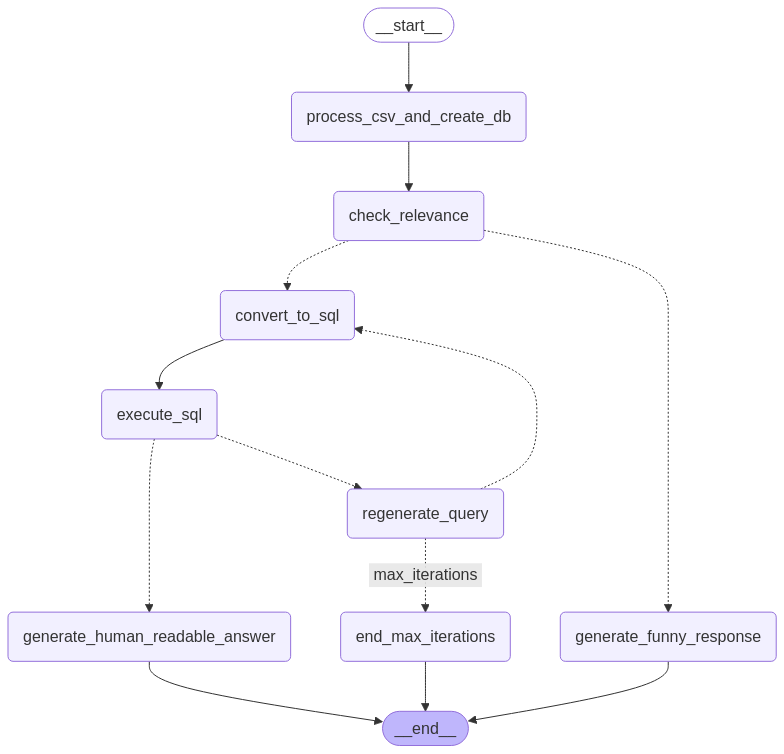

In [358]:
display(Image(app.get_graph(xray=1).draw_mermaid_png()))

In [367]:
user_question_1 = "what are the columns in the dataset"
initial_state = {
	"csv_path": "train.csv",  
	"question": user_question_1,
	"attempts": 0,
	"data_database_name": settings.database_name,
	"memory_database_name": "memory_db",
	"table_name": "data_table",
	"sql_error": False,
	"analysis_goal": "",
	"max_analysts": 3,
	"human_analyst_feedback": None,
	"data_df": {},
	"ml_models": {},
	"visualizations": {},
	"database_schema": None,
	"analysis_summary": None,
	"memory_saver": None,
	"data_engine": None,
	"sql_query": "",
	"query_result": "",
	"query_rows": "",
	"relevance": ""
}

result_1 = app.invoke(initial_state)
print("Result:", result_1["query_result"])

Checking relevance of the question: what are the columns in the dataset
Relevance determined: relevant
Converting question to SQL for user: what are the columns in the dataset
Generated SQL query: SELECT column_name FROM information_schema.columns WHERE table_name = 'data_table';
Executing SQL query: SELECT column_name FROM information_schema.columns WHERE table_name = 'data_table';
Raw SQL Query Result: [{'column_name': 'id'}, {'column_name': 'passengerid'}, {'column_name': 'survived'}, {'column_name': 'pclass'}, {'column_name': 'age'}, {'column_name': 'sibsp'}, {'column_name': 'parch'}, {'column_name': 'fare'}, {'column_name': 'cabin'}, {'column_name': 'name'}, {'column_name': 'sex'}, {'column_name': 'ticket'}, {'column_name': 'embarked'}]
SQL SELECT query executed successfully.
Generating a human-readable answer.
Generated human-readable answer.
Result: content="Hello! \n\nI have retrieved the list of columns from the 'data_table'. Here they are:\n\n- id\n- passengerid\n- survived\n

In [366]:
user_question_2 = "how many passengers survived"
initial_state = {
	"csv_path": "train.csv",  
	"question": user_question_2,
	"attempts": 0,
	"data_database_name": settings.database_name,
	"memory_database_name": "memory_db",
	"table_name": "data_table",
	"sql_error": False,
	"analysis_goal": "",
	"max_analysts": 3,
	"human_analyst_feedback": None,
	"data_df": {},
	"ml_models": {},
	"visualizations": {},
	"database_schema": None,
	"analysis_summary": None,
	"memory_saver": None,
	"data_engine": None,
	"sql_query": "",
	"query_result": "",
	"query_rows": "",
	"relevance": ""
}

result_2 = app.invoke(initial_state)
print("Result:", result_2["query_result"])

Checking relevance of the question: how many passengers survived
Relevance determined: relevant
Converting question to SQL for user: how many passengers survived
Generated SQL query: SELECT COUNT(*) AS survived_count FROM data_table WHERE survived = 1;
Executing SQL query: SELECT COUNT(*) AS survived_count FROM data_table WHERE survived = 1;
Raw SQL Query Result: [{'survived_count': 342}]
SQL SELECT query executed successfully.
Generating a human-readable answer.
Generated human-readable answer.
Result: content='Hello, \n\nThere were a total of 342 passengers who survived.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 242, 'total_tokens': 257, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a93

In [368]:
query_result = result_1["query_result"]

# Extract only the "content" tuple
content_tuple = next((item for item in query_result if item[0] == "content"), None)

# Get the content text
content_text = content_tuple[1] if content_tuple else "No content found."

formatted_output = f"\n{content_text}"

print(formatted_output)



Hello! 

I have retrieved the list of columns from the 'data_table'. Here they are:

- id
- passengerid
- survived
- pclass
- age
- sibsp (siblings/spouses aboard)
- parch (parents/children aboard)
- fare
- cabin
- name
- sex
- ticket
- embarked

If you need further assistance or details, just let me know!
